# Detecting COVID-19 in Lung X-rays using Convolutional Neural Networks
## Author: Garda Ramadhito
## Date: 3/9/2021

The COVID-19 pandemic has ravaged the entire world, causing a large number of deaths among the elderly and those with underlying health conditions. Among the symptoms of COVID-19 include the presence of ground-glass opacities (GGOs) in one's lungs, which could indicate the severity of the disease in one's body. The GGOs can be shown in the COVID positive lungs in the visualization section below; they are areas of hazy opacification because of air displacement by fluid, airway collapse, fibrosis, or a neoplastic process. Quick detection of these GGOs in the lungs of COVID-19 positive patients would help medical workers to dedicate more attention to those with more severe symptoms on top of standard tests to diagnose COVID-19. In addition, this would allow medical workers to distinguish and separate those with common viral pneumonia, which is more treatable, from those with COVID-19, which is novel to the human immune system.

Artificial intelligence, specifically convolutional neural networks (CNN), is proven to be highly effective in this quick detection. In a paper written by Chowdhury et al., the authors are able to create a CNN model that can distinguish COVID-infected lungs from normal lungs and viral pneumonia-infected lungs. Their best model is accurate up to 97.74% using the CheXNet framework without image augmentation or up to 97.94% with the DenseNet201 framework with image augmentation. This study aims to replicate the paper's findings. The dataset used consists of 1200 COVID-positive lung X-rays, 1341 normal lung X-rays, and 1345 viral pneumonia-infected lung X-rays. The X-rays are different from the images used in Chowdhury et al.'s paper.

The findings of this report support the paper's general conclusion that AI is highly effective at screening COVID-infected lungs from those infected with viral pneumonia and normal lungs. My plain vanilla CNN model returns an accuracy of 95.63%. My SqueezeNet model returns an accuracy of 93.44%. However, my best performing model, CheXNet, which is also Chowdhury et al.'s best performing model without image augmentation, returns the highest accuracy of 97.43%. CheXNet has a much higher number of layers than the plain vanilla CNN model and the SqueezeNet model as CheXNet uses the Dense121 weight through Transfer Learning. Also, increasing the epochs of the models increased the accuracy of the models in general.

The GitHub repository where this notebook is located can be found [here](https://github.com/mramadhito/COVID-19-Lungs).

Works cited:

Chowdhury, Muhammad EH, et al. "Can AI help in screening viral and COVID-19 pneumonia?." *IEEE Access 8* (2020): 132665-132676. https://arxiv.org/abs/2003.13145

### Setup and Data Preprocessing

In [ ]:
# Import data and unzip files to folder
!gdown --id 1xt7g5LkZuX09e1a8rK9sRXIrGFN6rjzl
!unzip COVID-19_Radiography_Database.zip 

In [1]:
# Colab Setup: 
# note that tabular preprocessors require scikit-learn>=0.24.0
# Newest Tensorflow 2 has some bugs for onnx conversion
!pip install scikit-learn --upgrade 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [3]:
# Extracting all filenames iteratively
base_path = 'COVID-19 Radiography Database'
categories = ['COVID', 'NORMAL', 'Viral Pneumonia']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [1200, 1341, 1345]
[['COVID-19 Radiography Database/COVID/COVID (410).png', 'COVID-19 Radiography Database/COVID/COVID (213).png', 'COVID-19 Radiography Database/COVID/COVID (597).png', 'COVID-19 Radiography Database/COVID/COVID (119).png', 'COVID-19 Radiography Database/COVID/COVID (634).png', 'COVID-19 Radiography Database/COVID/COVID (1187).png', 'COVID-19 Radiography Database/COVID/COVID (610).png', 'COVID-19 Radiography Database/COVID/COVID (167).png', 'COVID-19 Radiography Database/COVID/COVID (510).png', 'COVID-19 Radiography Database/COVID/COVID (655).png', 'COVID-19 Radiography Database/COVID/COVID (700).png', 'COVID-19 Radiography Database/COVID/COVID (1092).png', 'COVID-19 Radiography Database/COVID/COVID (250).png', 'COVID-19 Radiography Database/COVID/COVID (15).png', 'COVID-19 Radiography Database/COVID/COVID (1060).png', 'COVID-19 Radiography Database/COVID/COVID (1105).png', 'COVID-19 Radiography Database/COVID/COVID (64).png', 'COVID

In [4]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Uses opencv for image preprocessing

def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        #grayscale image?  Use im_gray = cv2.imread('gray_image.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.  

        # Resize the images.
        X = np.array(img)
        #X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels] if needed.
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

#Try on single COVID photo file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19 Radiography Database/COVID/COVID (1).png').shape

(192, 192, 3)

In [5]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [6]:
len(image_filepaths)

3886

In [7]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


3886
(3886, 192, 192, 3)
0.0
1.0


In [8]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1200))
normal=list(repeat("NORMAL", 1341))
pneumonia=list(repeat("PNEUMONIA", 1345))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels))

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1200, 1341, 1345]
3886


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
3881,0,0,1
3882,0,0,1
3883,0,0,1
3884,0,0,1


### Visualization of different lung categories


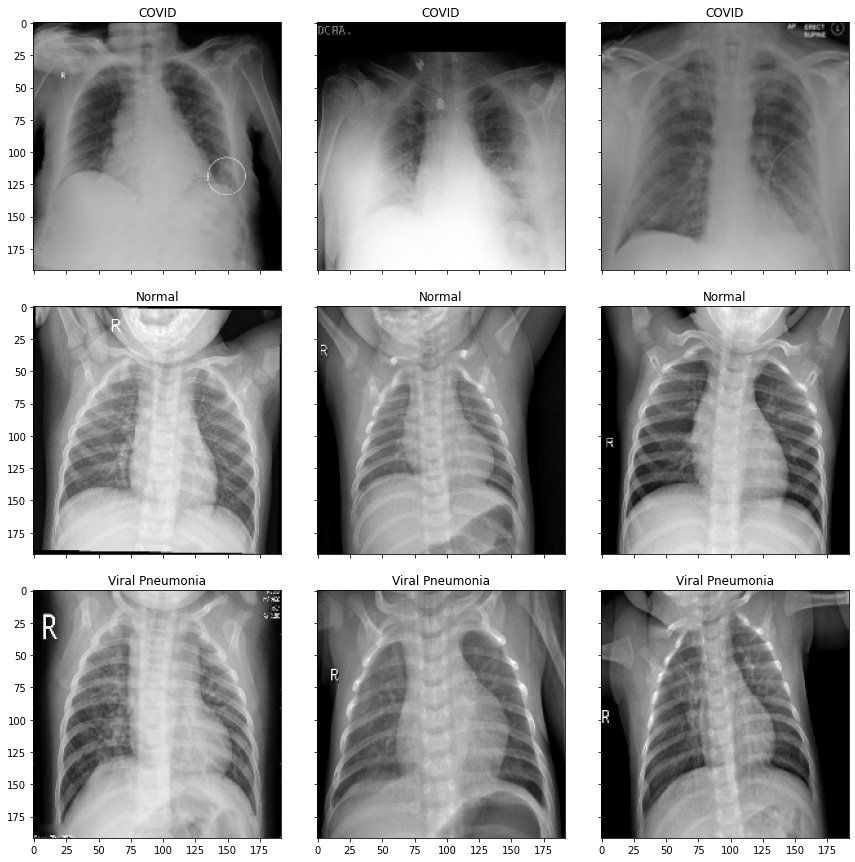

In [9]:
import random 

COVID_pics = random.sample(fnames[0], 3)
Normal_pics = random.sample(fnames[1], 3)
Pneumonia_pics = random.sample(fnames[2], 3)

pics = COVID_pics + Normal_pics + Pneumonia_pics

lung_images = []

for pic in pics:
  lung_images.append(preprocessor(pic))

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 3x3 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 )

lung_cats = ["COVID"] * 3 + ["Normal"] * 3 + ["Viral Pneumonia"] * 3
i = 0
for ax, im in zip(grid, lung_images):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.set_title(lung_cats[i])
    i = i + 1
plt.show()

### Split image data into train and test samples

In [10]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)


y_test.sum()

COVID        240
NORMAL       269
PNEUMONIA    269
dtype: int64

#### Model 1: Plain Vanilla Convolutional Neural Network


In [11]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model1 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 5 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model1.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model1.fit(X_train, y_train, 
                    epochs = 25, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 3108 samples, validate on 778 samples
Epoch 1/25
3108/3108 [==============================] - 9s 3ms/sample - loss: 0.9340 - acc: 0.4762 - val_loss: 0.8522 - val_acc: 0.6028
Epoch 2/25
3108/3108 [==============================] - 5s 2ms/sample - loss: 0.6374 - acc: 0.6908 - val_loss: 0.5608 - val_acc: 0.7609
Epoch 3/25
3108/3108 [==============================] - 5s 2ms/sample - loss: 0.4444 - acc: 0.8279 - val_loss: 0.3609 - val_acc: 0.8869
Epoch 4/25
3108/3108 [==============================] - 5s 2ms/sample - loss: 0.2866 - acc: 0.9028 - val_loss: 0.2548 - val_acc: 0.9113
Epoch 5/25
3108/3108 [==============================] - 5s 2ms/sample - loss: 0.2365 - acc: 0.9154 - val_loss: 0.2232 - val_acc: 0.9190
Epoch 6/25
3108/3108 [==============================] - 5s 2ms/sample - loss: 0.2062 - acc: 0.9260 - val_loss: 0.2695 - val_acc: 0.9100
Epoch 7/25
3108/3108 [==============================] - 

In [12]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model1.predict(X_test)))

prediction_index1=predict_classes(model1.predict(X_test))

[2 2 0 1 2 0 1 0 1 2 1 1 0 2 0 0 0 0 1 2 2 2 1 0 2 2 2 2 1 2 1 0 1 2 2 0 2
 1 0 0 0 0 2 0 1 1 0 0 2 1 2 0 2 1 1 1 1 0 1 2 1 0 0 1 1 1 2 1 2 1 1 0 0 2
 1 1 1 1 0 1 0 1 2 1 0 2 1 0 0 1 2 2 2 2 0 2 0 1 2 0 1 0 0 1 2 1 0 2 0 0 0
 0 0 2 2 2 2 2 1 2 1 2 1 1 0 2 0 2 0 1 2 2 1 0 0 0 2 0 1 0 0 1 1 2 1 0 0 0
 1 1 2 2 1 1 2 1 0 0 2 1 2 0 0 0 2 2 1 0 0 0 1 1 1 2 0 0 0 2 0 2 2 2 1 1 2
 2 0 2 1 1 2 1 0 2 2 1 2 1 2 2 0 1 0 1 0 1 0 2 1 1 1 2 0 0 1 1 1 1 2 1 2 0
 2 2 2 0 2 1 2 1 1 2 0 1 1 1 1 1 0 2 1 1 0 2 2 0 2 0 1 1 0 2 1 0 2 2 2 0 2
 0 1 0 1 2 2 1 2 1 1 1 0 2 0 2 2 2 2 2 2 1 1 0 2 2 0 0 0 2 0 2 2 1 0 2 1 2
 2 0 1 0 0 1 2 0 1 2 0 0 1 2 0 1 2 2 1 0 1 2 0 2 1 2 1 0 2 1 2 2 1 1 0 2 0
 1 0 0 2 1 1 2 2 0 0 2 0 2 0 2 1 2 0 1 2 0 1 0 2 2 1 0 0 0 1 0 1 0 0 2 1 0
 0 2 0 0 1 2 2 0 2 0 2 1 1 2 0 1 1 2 0 0 2 0 2 1 1 2 2 0 0 1 2 2 0 1 0 0 2
 2 2 2 0 1 2 2 0 2 2 0 1 0 0 0 0 1 2 2 1 1 1 1 0 2 1 1 2 1 2 0 2 2 0 2 2 2
 2 0 0 0 0 2 1 1 2 2 2 2 1 2 1 2 1 1 2 2 1 2 2 2 0 1 0 2 0 1 2 0 2 0 1 2 2
 1 1 1 1 1 0 1 0 2 1 0 2 

In [13]:
#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels1=list(map(lambda x: labels[x], prediction_index1))
print(predicted_labels1)


['PNEUMONIA', 'PNEUMONIA', 'COVID', 'NORMAL', 'PNEUMONIA', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'COVID', 'PNEUMONIA', 'COVID', 'COVID', 'COVID', 'COVID', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'COVID', 'COVID', 'COVID', 'COVID', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'COVID', 'COVID', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'COVID', 'COVID', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'NORMAL', 'COVID', 'COVID', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA'

In [14]:
# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

In [15]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels


In [16]:
# get metrics
model_eval_metrics(y_test_labels,predicted_labels1,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.956298,0.956907,0.957238,0.95727,0,0,0,0


### Model 2: SqueezeNet

In [17]:
l = tf.keras.layers # syntax shortcut

# Create function to define fire modules
def fire(x, squeeze, expand):
  y = l.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x) 
  y1 = l.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y) # note: //2 takes input value and divides by 2, so we reach the dimensions requested with stacking later.
  y3 = l.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
  return tf.keras.layers.concatenate([y1, y3])

# this is to make it behave similarly to other Keras layers
def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)


with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  x = tf.keras.layers.Input(shape=[192,192, 3]) # input is 192x192 pixels RGB

  y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.GlobalAveragePooling2D()(y) # Takes average of h x w for each channel and returns 1 scalar value per channel
  y = tf.keras.layers.Dense(3, activation='softmax')(y) # Parameters for final layer from GAP = number of channels in previous layer plus number of dense nodes in output layer times number of dense nodes

  model2 = tf.keras.Model(x, y)

  model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

  model2.fit(X_train, y_train, 
          epochs = 25, verbose=1,validation_data=(X_test,y_test))

Train on 3108 samples, validate on 778 samples
Epoch 1/25
3108/3108 [==============================] - 13s 4ms/sample - loss: 0.6761 - acc: 0.6731 - val_loss: 0.4168 - val_acc: 0.8342
Epoch 2/25
3108/3108 [==============================] - 10s 3ms/sample - loss: 0.3816 - acc: 0.8584 - val_loss: 0.3442 - val_acc: 0.8728
Epoch 3/25
3108/3108 [==============================] - 10s 3ms/sample - loss: 0.2697 - acc: 0.9064 - val_loss: 0.2767 - val_acc: 0.9139
Epoch 4/25
3108/3108 [==============================] - 10s 3ms/sample - loss: 0.2426 - acc: 0.9183 - val_loss: 0.2177 - val_acc: 0.9306
Epoch 5/25
3108/3108 [==============================] - 10s 3ms/sample - loss: 0.1888 - acc: 0.9344 - val_loss: 0.2378 - val_acc: 0.8985
Epoch 6/25
3108/3108 [==============================] - 10s 3ms/sample - loss: 0.1679 - acc: 0.9402 - val_loss: 0.2720 - val_acc: 0.9357
Epoch 7/25
3108/3108 [==============================] - 10s 3ms/sample - loss: 0.1779 - acc: 0.9356 - val_loss: 0.1802 - val_acc: 0

In [21]:
prediction_index2=predict_classes(model2.predict(X_test))

predicted_labels2=list(map(lambda x: labels[x], prediction_index2))
print(predicted_labels2)

['PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'COVID', 'PNEUMONIA', 'COVID', 'COVID', 'COVID', 'COVID', 'NORMAL', 'COVID', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'COVID', 'COVID', 'COVID', 'COVID', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'COVID', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'COVID', 'COVID', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'NORMAL', 'COVID', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'COVID', 'PNEUMON

In [20]:
model_eval_metrics(y_test_labels,predicted_labels2,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.934447,0.933994,0.93689,0.936803,0,0,0,0


### Model 3: CheXNet (Transfer Learning)

##### Created by Pranav Rajpurkar, Jeremy Irvin, Kaylie Zhu, Brandon Yang, Hershel Mehta, Tony Duan, Daisy Ding, Aarti Bagul, Curtis Langlotz, Katie Shpanskaya, Matthew P. Lungren, Andrew Y. Ng. [Source](https://stanfordmlgroup.github.io/projects/chexnet/)

##### Reproduced by Mohammad Sadegh Akhondzadeh. [Source](https://github.com/msadegh97/CheXNet-implementation-in-Keras)

In [22]:
import keras
from keras.applications.densenet import DenseNet121
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam

input_shape = (192, 192, 3)
num_of_class = 3
img_in = Input(input_shape)              #input of model 
model3 = DenseNet121(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= input_shape,
                pooling ='avg')

x = model3.output  
predictions = Dense(num_of_class, activation="sigmoid", name="predictions")(x)    # fuly connected layer for predict class 
model3 = Model(inputs=img_in, outputs=predictions)

Using TensorFlow backend.


In [23]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 192, 192, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 198, 198, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 96, 96, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 96, 96, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [24]:
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

model3.fit(X_train, y_train, epochs = 25, verbose=1,validation_data=(X_test,y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 3108 samples, validate on 778 samples
Epoch 1/25
3108/3108 [==============================] - 61s 20ms/step - loss: 0.1944 - accuracy: 0.9389 - val_loss: 3.7882 - val_accuracy: 0.4460
Epoch 2/25
3108/3108 [==============================] - 33s 11ms/step - loss: 0.1326 - accuracy: 0.9527 - val_loss: 1.6984 - val_accuracy: 0.5566
Epoch 3/25
3108/3108 [==============================] - 33s 11ms/step - loss: 0.0919 - accuracy: 0.9720 - val_loss: 0.4883 - val_accuracy: 0.8406
Epoch 4/25
3108/3108 [==============================] - 33s 11ms/step - loss: 0.0815 - accuracy: 0.9720 - val_loss: 0.1823 - val_accuracy: 0.9370
Epoch 5/25
3108/3108 [==============================] - 33s 11ms/step - loss: 0.0809 - accuracy: 0.9714 - val_loss: 1.3410 - val_accuracy: 0.7391
Epoch 6/25
3108/3108 [==============================] - 33s 11ms/step - loss: 0.0446 - accuracy: 0.9833 - val_loss: 10.9633 - va

In [25]:
prediction_index3=predict_classes(model3.predict(X_test))

predicted_labels3=list(map(lambda x: labels[x], prediction_index3))
print(predicted_labels3)

['PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'COVID', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'COVID', 'COVID', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'COVID', 'COVID', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'P

In [27]:
model_eval_metrics(y_test_labels,predicted_labels3,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.974293,0.975008,0.975742,0.974618,0,0,0,0


### Export to AIModelShare

In [ ]:
# test with aimodelshare library
! pip install aimodelshare --upgrade --extra-index-url https://test.pypi.org/simple/ 

In [28]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") #ignore error "can't pickle module objects"

In [ ]:
from aimodelshare.aimsonnx import model_to_onnx
# transform sklearn model to ONNX
Ramadhito_CheXNet_onnx = model_to_onnx(model3, framework='keras', 
                                   transfer_learning=True,
                                   deep_learning=True,
                                   task_type='classification') #DenseNet121 does not work with model_to_onnx

# Save model to local .onnx file
with open("Ramadhito_CheXNet_onnx.onnx", "wb") as f:
    f.write(Ramadhito_CheXNet_onnx.SerializeToString())

#This will produce an error so export next best model instead

In [38]:
# Transform next best model (Plain Vanilla CNN)

Ramadhito_CNN_onnx = model_to_onnx(model1, framework='keras', 
                                   transfer_learning=False,
                                   deep_learning=True,
                                   task_type='classification')

with open("Ramadhito_CNN_onnx.onnx", "wb") as f:
    f.write(Ramadhito_CNN_onnx.SerializeToString())


The ONNX operator number change on the optimization: 100 -> 45


In [39]:
# Set credentials to submit new model/preprocessor

from aimodelshare.aws import set_credentials
set_credentials(credential_file="credentials.txt", type="submit_model", apiurl="https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m") #Covid image prediction apiURL

AI Model Share login credentials set successfully.
AWS credentials set successfully.


In [40]:
import aimodelshare as ai
import os
token=ai.aws.get_aws_token(os.environ.get("username"), os.environ.get("password"))
awscreds=ai.aws.get_aws_client(aws_key=os.environ.get('AWS_ACCESS_KEY_ID'), aws_secret=os.environ.get('AWS_SECRET_ACCESS_KEY'), aws_region=os.environ.get('AWS_REGION'))

In [41]:
# Submit_model() to leaderboard
ai.submit_model("Ramadhito_CNN_onnx.onnx",
                "https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,prediction_submission=predicted_labels1,
                preprocessor="preprocessor.zip")

'Your model has been submitted as model version 52'

In [42]:
import pandas
data=ai.get_leaderboard("https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,verbose=1)

#get rid of any duplicate model submissions
#data=data.loc[data.iloc[:,0:8].duplicated()==False,:]
data.fillna(0,inplace=True)
data

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,loss,optimizer,model_config,username,timestamp,version
0,0.992288,0.992486,0.992412,0.992565,keras,True,True,Model,26,39162947,str,Adam,"{'name': 'model_11', 'layers': [{'name': 'inpu...",dv2438,2021-03-07 23:02:41.978914,45
1,0.985861,0.986088,0.986470,0.985770,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': [{'name': 'input...",kagenlim,2021-03-04 02:49:57.183806,7
2,0.985861,0.986088,0.986470,0.985770,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': [{'name': 'input...",kagenlim,2021-03-04 02:50:38.718996,8
3,0.983290,0.983636,0.983446,0.983891,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'layers': [{'class_na...",prajseth,2021-03-08 00:43:34.857578,48
4,0.980720,0.981091,0.981226,0.981263,keras,False,True,Model,26,39162947,str,Adam,"{'name': 'model_12', 'layers': [{'name': 'inpu...",dv2438,2021-03-06 16:06:55.748014,26
5,0.979434,0.979710,0.979604,0.980173,keras,True,True,Model,313,21808931,str,Adam,"{'name': 'model_4', 'layers': [{'name': 'input...",prajseth,2021-03-08 02:34:38.630185,50
6,0.978149,0.978550,0.978470,0.978635,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'layers': [{'class_na...",prajseth,2021-03-08 00:50:31.207727,49
7,0.975578,0.976001,0.975782,0.976456,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'layers': [{'class_na...",prajseth,2021-03-08 00:39:11.372915,47
8,0.975578,0.976024,0.975700,0.976456,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'layers': [{'class_na...",prajseth,2021-03-07 08:55:54.375970,40
9,0.970437,0.971197,0.971771,0.970751,keras,True,True,Model,313,21808931,str,SGD,"{'name': 'model_6', 'layers': [{'name': 'input...",mro9395,2021-03-05 21:57:59.450067,22


In [43]:
ai.stylize_leaderboard(data,category="classification")

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,loss,optimizer,model_config,username,version
0,99.23%,99.25%,99.24%,99.26%,keras,True,True,Model,26,39162947,str,Adam,"{'name': 'model_11', 'layers':...",dv2438,45
1,98.59%,98.61%,98.65%,98.58%,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': ...",kagenlim,7
2,98.59%,98.61%,98.65%,98.58%,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': ...",kagenlim,8
3,98.33%,98.36%,98.34%,98.39%,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'laye...",prajseth,48
4,98.07%,98.11%,98.12%,98.13%,keras,False,True,Model,26,39162947,str,Adam,"{'name': 'model_12', 'layers':...",dv2438,26
5,97.94%,97.97%,97.96%,98.02%,keras,True,True,Model,313,21808931,str,Adam,"{'name': 'model_4', 'layers': ...",prajseth,50
6,97.81%,97.85%,97.85%,97.86%,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'laye...",prajseth,49
7,97.56%,97.60%,97.58%,97.65%,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'laye...",prajseth,47
8,97.56%,97.60%,97.57%,97.65%,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'laye...",prajseth,40
9,97.04%,97.12%,97.18%,97.08%,keras,True,True,Model,313,21808931,str,SGD,"{'name': 'model_6', 'layers': ...",mro9395,22
